# NLP Task: Detecting Offensive Language in Social Media

Social media platforms are increasingly plagued by offensive content. This notebook builds a text classification system to categorise tweets as **Not Offensive (NOT)**, **Targeted Insult (TIN)**, or **Untargeted (UNT)**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_colwidth', None)

## Step 1 -- Load and Inspect the Data

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

print(f"Training samples: {df_train.shape[0]}")
print(f"Test samples:     {df_test.shape[0]}")
print(f"\nLabel distribution:\n{df_train['label'].value_counts()}")

Training samples: 13240
Test samples:     460

Label distribution:
label
NOT    8840
TIN    3876
UNT     524
Name: count, dtype: int64


/var/folders/vs/x19kdrj5745dth8q9zptl1km0000gn/T/ipykernel_16931/1158852339.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x='label', order=['NOT', 'TIN', 'UNT'], palette='coolwarm')


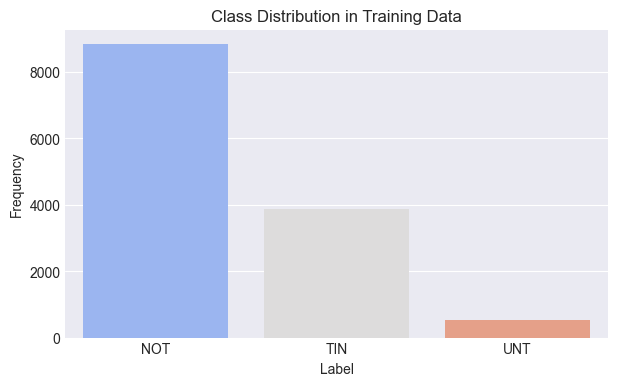

In [3]:
plt.figure(figsize=(7, 4))
sns.countplot(data=df_train, x='label', order=['NOT', 'TIN', 'UNT'], palette='coolwarm')
plt.title('Class Distribution in Training Data')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.savefig('nlp_dist_v2.png', dpi=150, bbox_inches='tight')
plt.show()

The dataset is significantly skewed towards the NOT class. TIN is moderately represented while UNT is rare.

## Step 2 -- Text Preprocessing
We apply Porter stemming (reducing words to root forms via suffix stripping) rather than lemmatization. Crucially, we retain stopwords because function words like "you", "your" often carry signal in abusive language directed at individuals.

In [4]:
stemmer = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\burl\b', '', text)
    text = re.sub(r'@user', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [stemmer.stem(w) for w in words]
    return ' '.join(words)

print("Preprocessing training data...")
df_train['processed'] = df_train['tweet'].apply(preprocess)

print("Preprocessing test data...")
df_test['processed'] = df_test['tweet'].apply(preprocess)

df_train[['tweet', 'processed']].head(3)

Preprocessing training data...


Preprocessing test data...


,tweet,processed
0,@USER She should ask a few native Americans what their take on this is.,she should ask a few nativ american what their take on thi is
1,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,go home your drunk maga trump
2,Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT,amazon is investig chines employe who are sell intern data to thirdparti seller look for an edg in the competit marketplac amazon maga kag china tcot


## Step 3 -- Feature Extraction and Splitting
We use a Bag-of-Words (CountVectorizer) approach with unigrams only and a vocabulary cap of 5,000 terms. BoW captures raw term frequencies, pairing naturally with probabilistic and linear classifiers.

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train['processed'],
    df_train['label'],
    test_size=0.3,
    random_state=100
)

bow = CountVectorizer(max_features=5000, ngram_range=(1, 1), min_df=2)

X_train_bow = bow.fit_transform(X_train)
X_val_bow = bow.transform(X_val)

print(f"BoW feature matrix shape: {X_train_bow.shape}")

BoW feature matrix shape: (9268, 5000)


## Step 4 -- Model Training and Evaluation
We benchmark three classifiers not used in typical baselines:
1. **Logistic Regression** -- a strong linear model with built-in regularisation.
2. **Decision Tree** -- a non-linear, interpretable model.
3. **SGD Classifier** -- a scalable linear model using stochastic gradient descent.

In [6]:
def train_and_evaluate(model, name):
    model.fit(X_train_bow, y_train)
    preds = model.predict(X_val_bow)
    acc = accuracy_score(y_val, preds)
    wf1 = f1_score(y_val, preds, average='weighted')
    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f} | Weighted F1: {wf1:.4f}\n")
    return model, preds, acc, wf1

lr_model, lr_preds, lr_acc, lr_f1 = train_and_evaluate(
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=100),
    "Logistic Regression"
)

dt_model, dt_preds, dt_acc, dt_f1 = train_and_evaluate(
    DecisionTreeClassifier(max_depth=50, class_weight='balanced', random_state=100),
    "Decision Tree"
)

sgd_model, sgd_preds, sgd_acc, sgd_f1 = train_and_evaluate(
    SGDClassifier(loss='hinge', class_weight='balanced', random_state=100),
    "SGD Classifier"
)

--- Logistic Regression ---
Accuracy: 0.6921 | Weighted F1: 0.7014



--- Decision Tree ---
Accuracy: 0.6511 | Weighted F1: 0.6367

--- SGD Classifier ---
Accuracy: 0.7059 | Weighted F1: 0.7063



In [7]:
results = {
    'Logistic Regression': (lr_acc, lr_f1, lr_model, lr_preds),
    'Decision Tree':       (dt_acc, dt_f1, dt_model, dt_preds),
    'SGD Classifier':      (sgd_acc, sgd_f1, sgd_model, sgd_preds),
}
best_name = max(results, key=lambda k: results[k][1])
best_acc, best_f1, best_model, best_preds = results[best_name]
print(f"Best model by Weighted F1: {best_name} ({best_f1:.4f})")

Best model by Weighted F1: SGD Classifier (0.7063)


## Step 5 -- Detailed Best-Model Analysis

Classification Report -- SGD Classifier:
              precision    recall  f1-score   support

         NOT       0.80      0.82      0.81      2638
         TIN       0.57      0.51      0.54      1177
         UNT       0.17      0.24      0.20       157

    accuracy                           0.71      3972
   macro avg       0.52      0.52      0.52      3972
weighted avg       0.71      0.71      0.71      3972



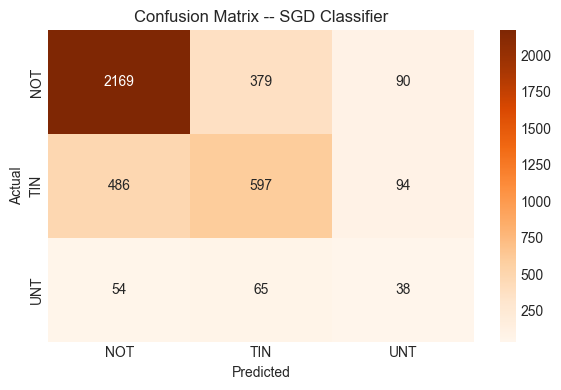

In [8]:
print(f"Classification Report -- {best_name}:")
print(classification_report(y_val, best_preds))

cm = confusion_matrix(y_val, best_preds, labels=best_model.classes_)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title(f'Confusion Matrix -- {best_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('nlp_cm_v2.png', dpi=150)
plt.show()

## Step 6 -- Generate Test Predictions

In [9]:
X_test_bow = bow.transform(df_test['processed'])
predictions = best_model.predict(X_test_bow)

df_test['prediction'] = predictions
df_out = df_test[['id', 'tweet', 'prediction']]
df_out.to_csv('test-predictions_v2.csv', index=False)

print(f"Saved {len(df_out)} predictions to test-predictions_v2.csv")
df_out.head()

Saved 460 predictions to test-predictions_v2.csv


,id,tweet,prediction
0,15923,"#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA Democrats Support Antifa, Muslim Brotherhood, MS13, ISIS, Pedophilia, Child Trafficking, Taxpayer Funded Abortion’s, Election Fraud, Sedition And Treason!!! #LockThemAllUp #WWG1WGA #QAnon ⁦@USER URL",TIN
1,27014,"#ConstitutionDay is revered by Conservatives, hated by Progressives/Socialist/Democrats that want to change it.",NOT
2,30530,"#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendment #RNC #USMC #veterans @USER @USER @USER @USER @USER #fakereporting #THESWAMP #dnc #liberals @USER @USER #fakeoutrage @USER First, it reduces the ca URL",NOT
3,13876,#Watching #Boomer getting the news that she is still up for parole always makes me smile. #Wentworth Finale...@USER is such a treasure. URL,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right in #London – #antifa #Oct13 — Enough is Enough! URL,NOT
